# Transformation(**optional**)

In case you want to transform images to our training set

Processed 5851.jpg and applied settings


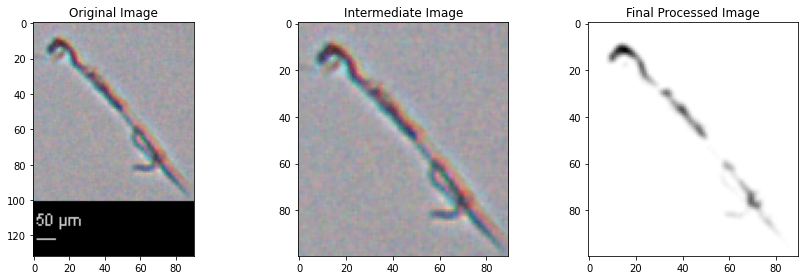

Processed 6164.jpg and applied settings


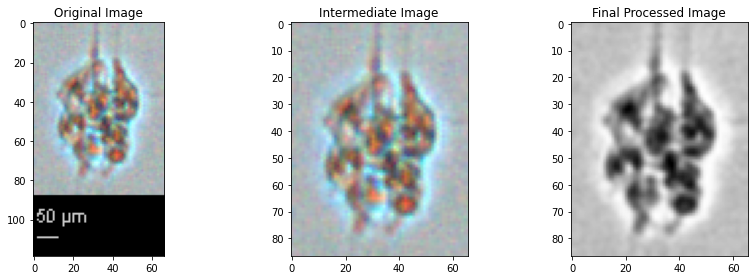

Skipped chaetoceros due to missing image
Skipped chaetoceros_vliz due to missing image
Skipped ecotaxa.obs-vlfr.fr_explore_.html due to missing image
Skipped ecotaxa.obs-vlfr.fr_explore__files due to missing image
Skipped guinardia due to missing image
Skipped guinardia_vliz due to missing image


In [56]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Replace with your actual paths
original_images_folder = '/srv/phyto-plankton-classification/data/images/Actinoptychus'
new_images_folder = '/srv/phyto-plankton-classification/data/change_images/start'
output_folder = '/srv/phyto-plankton-classification/data/change_images/end'
intermediate_folder = '/srv/phyto-plankton-classification/data/change_images/middle'

# Adjustable Parameters
noise_std = 0
kernel_size = 3
threshold = 0.2

def apply_settings_to_image(image, brightness, contrast):
    # Adjust brightness and contrast
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
    return adjusted_image

def calculate_average_grayscale_stats(image_folder):
    image_files = os.listdir(image_folder)
    total_intensity = 0
    total_contrast = 0
    total_images = len(image_files)

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is not None:
            total_intensity += np.mean(image)
            total_contrast += np.std(image)

    average_intensity = total_intensity / total_images
    average_contrast = total_contrast / total_images

    return average_intensity, average_contrast


def find_continuous_indices(arr, threshold_value, continuous_count):
    above_threshold = arr > threshold_value
    indices = np.where(above_threshold)[0]
    continuous_indices = []
    temp = []

    for idx in indices:
        if len(temp) == 0 or idx == temp[-1] + 1:
            temp.append(idx)
        else:
            temp = [idx]

        if len(temp) >= continuous_count:
            continuous_indices.extend(temp)
            
    return continuous_indices

def find_cropping_indices(indices_list, continuous_count):
    cropping_indices = []
    for i in range(len(indices_list) - continuous_count + 1):
        cropping_indices.append(indices_list[i:i+continuous_count])
    return cropping_indices

def remove_black_bars(image):
    threshold = 0.2
    row_sum = np.sum(image != 0, axis=1)
    col_sum = np.sum(image != 0, axis=0)

    continuous_count = 2

    bottom_cropping_indices = find_cropping_indices(find_continuous_indices(row_sum[::-1], threshold * image.shape[1], continuous_count), continuous_count)
    right_cropping_indices = find_cropping_indices(find_continuous_indices(col_sum[::-1], threshold * image.shape[0], continuous_count), continuous_count)

    max_bottom = 0
    max_right = 0

    for bottom_indices in bottom_cropping_indices:
        for right_indices in right_cropping_indices:
            bottom = image.shape[0] - bottom_indices[-1] if len(bottom_indices) > 0 else image.shape[0]
            right = image.shape[1] - right_indices[-1] if len(right_indices) > 0 else image.shape[1]

            if bottom > max_bottom:
                max_bottom = bottom
            if right > max_right:
                max_right = right

    cropped_image = image[:max_bottom, :max_right]
    return cropped_image

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Calculate original average grayscale stats
original_avg_brightness, original_avg_contrast = calculate_average_grayscale_stats(intermediate_folder)

# Process new images
new_image_files = os.listdir(new_images_folder)

for new_file in new_image_files:
    new_image_path = os.path.join(new_images_folder, new_file)
    new_color_image = cv2.imread(new_image_path)

    if new_color_image is None:
        print(f"Skipped {new_file} due to missing image")
        continue

    # Remove black bars
    cleaned_image = remove_black_bars(new_color_image)

    # Calculate brightness and contrast factors
    brightness_factor = original_avg_brightness / np.mean(cleaned_image)
    contrast_factor = original_avg_contrast / np.std(cleaned_image)

    # Calculate the average intensity of the new color image
    average_new_intensity = np.mean(cleaned_image)

    # Calculate the scaling factor based on the average intensities
    scaling_factor = original_avg_brightness / average_new_intensity

    # Adjust the intensity of the new color image
    adjusted_image = np.clip(cleaned_image * scaling_factor, 0, 255).astype(np.uint8)

    # Adjust brightness and contrast
    adjusted_image = apply_settings_to_image(adjusted_image, brightness_factor, contrast_factor)

    # Add noise
    noisy_image = adjusted_image + np.random.normal(0, noise_std, adjusted_image.shape).astype(np.uint8)

    # Apply blur
    blurred_image = cv2.GaussianBlur(noisy_image, (kernel_size, kernel_size), 0)

    # Convert the color image to grayscale
    grayscale_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

    # Save the final processed image as grayscale
    output_path = os.path.join(output_folder, new_file)
    cv2.imwrite(output_path, grayscale_image)

    print(f"Processed {new_file} and applied settings")

    # Display the original, intermediate, and final images using Matplotlib
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(new_color_image)

    plt.subplot(132)
    plt.title('Intermediate Image')
    plt.imshow(cleaned_image)

    plt.subplot(133)
    plt.title('Final Processed Image')
    plt.imshow(grayscale_image, cmap='gray')

    plt.tight_layout()
    plt.show()
